# Tema 4: Teleportación cuántica

Curso ICC02.

Autor: Alejandro Mata Ali

En este notebook vamos a trabajar la teleportación cuántica, a fin de fijar los conocimientos aprendidos de la anterior unidad. Vamos a implementar el circuito cuántico que vimos.

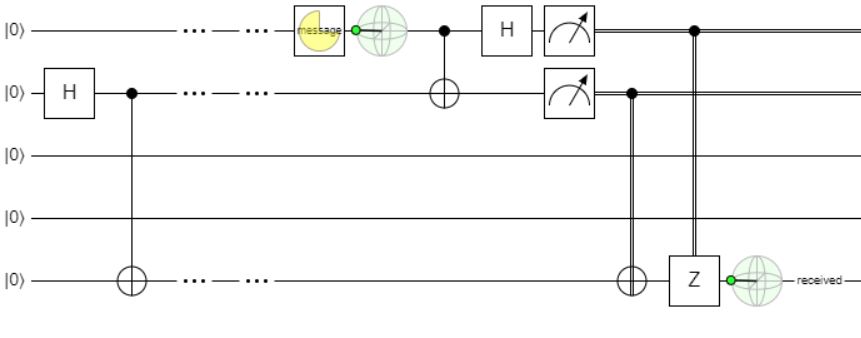

Obtendremos las cuentas de los qubits antes y después de la teleportación.

##Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts
import numpy as np

---
# Circuito cuántico

Vamos a empezar creando el circuito cuántico. Vamos a definir un registro para cada qubit y cada resultado de los 2 que tendrá Alice, para las correcciones.

In [2]:
#Creamos los registros separados
qrAlice = QuantumRegister(1, name='qrAlice')
qrMensajero = QuantumRegister(1, name='qrMensajero')
qrBob = QuantumRegister(1, name='qrBob')

crAlice = ClassicalRegister(1, name='crAlice')
crMensajero = ClassicalRegister(1, name='crMensajero')

#Creamos el circuito
qc = QuantumCircuit(qrAlice, qrMensajero, qrBob, crAlice, crMensajero)

#Entrelazamos el qubit mensajero con el de Bob
qc.h(qrMensajero[0])
qc.cx(qrMensajero[0], qrBob[0])

Inicializamos el estado que queremos en Alice.

In [3]:
#Vector de estado
state = np.array([0.75, 0.5])
state /= np.sqrt(sum(state**2))
#Inicializamos el qubit y normalizamos el vector
qc.initialize(state, qubits=qrAlice[0], normalize=True)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'qrAlice'), 0), Qubit(QuantumRegister(1, 'qrMensajero'), 0), Qubit(QuantumRegister(1, 'qrBob'), 0)), clbits=())

Añadimos los entrelazadores entre Alice y el mensajero y medimos.

In [4]:
qc.cx(qrAlice[0],qrMensajero[0])
qc.h(qrAlice[0])
qc.measure([qrAlice[0],qrMensajero[0]],[crAlice[0],crMensajero[0]])

Añadimos las operaciones de corrección condicionadas con los resultados de las mediciones.

In [5]:
with qc.if_test((crMensajero[0], 1)):
    qc.x(qrBob)
with qc.if_test((crAlice[0], 1)):
    qc.z(qrBob)

Comprobamos que está bien construido.

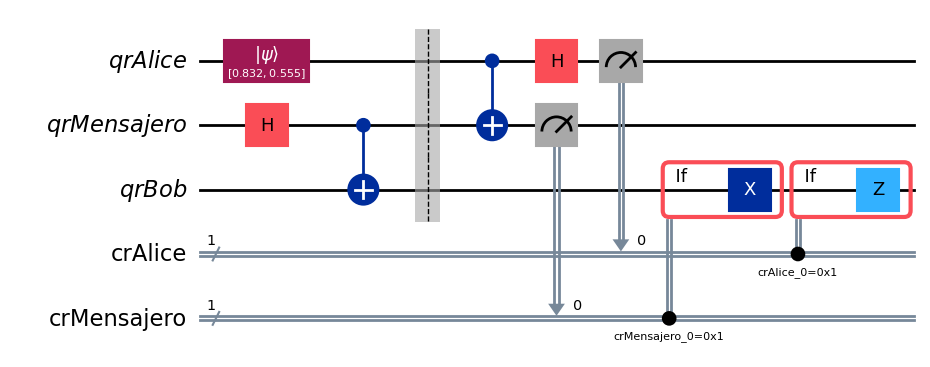

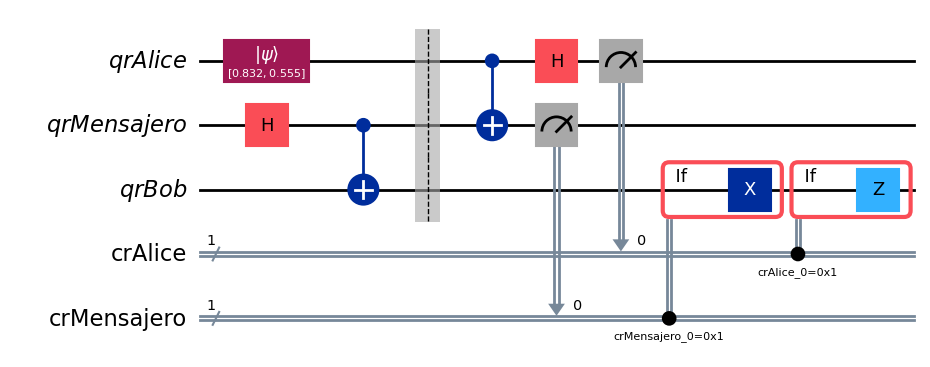

In [6]:
qc.draw('mpl')

Vamos a hacer que esto sea directamente una función.

In [11]:
def teleportacion(estado: np.array):
    #Creamos los registros separados
    qrAlice = QuantumRegister(1, name='qrAlice')
    qrMensajero = QuantumRegister(1, name='qrMensajero')
    qrBob = QuantumRegister(1, name='qrBob')

    crAlice = ClassicalRegister(1, name='crAlice')
    crMensajero = ClassicalRegister(1, name='crMensajero')

    #Creamos el circuito
    qc = QuantumCircuit(qrAlice, qrMensajero, qrBob, crAlice, crMensajero)

    #Entrelazamos el qubit mensajero con el de Bob
    qc.h(qrMensajero[0])
    qc.cx(qrMensajero[0], qrBob[0])

    #Inicializamos el qubit y normalizamos el vector
    qc.initialize(estado, qubits=qrAlice[0], normalize=True)
    qc.barrier()

    # Mediciones
    qc.cx(qrAlice[0],qrMensajero[0])
    qc.h(qrAlice[0])
    qc.measure([qrAlice[0],qrMensajero[0]],[crAlice[0],crMensajero[0]])

    # Aplicar las correcciones
    with qc.if_test((crMensajero[0], 1)):
        qc.x(qrBob)
    with qc.if_test((crAlice[0], 1)):
        qc.z(qrBob)

    return qc

---
# Comprobación del algoritmo

Obtengamos las cuentas finales.

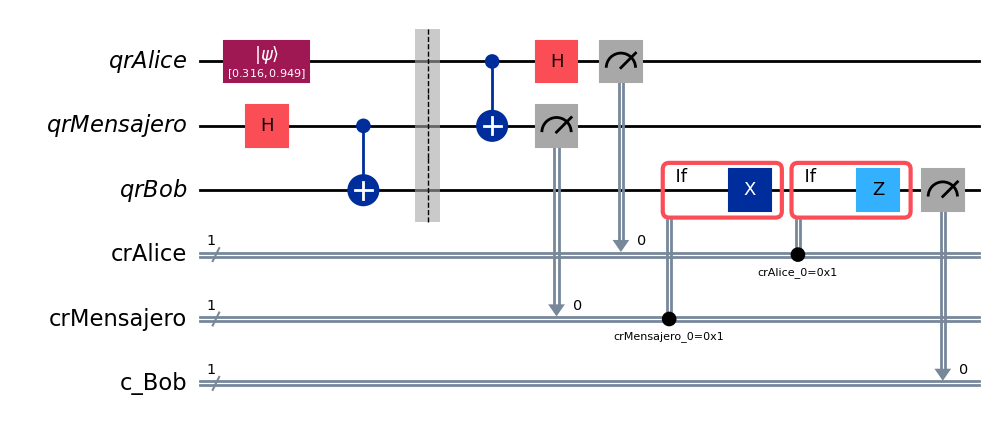

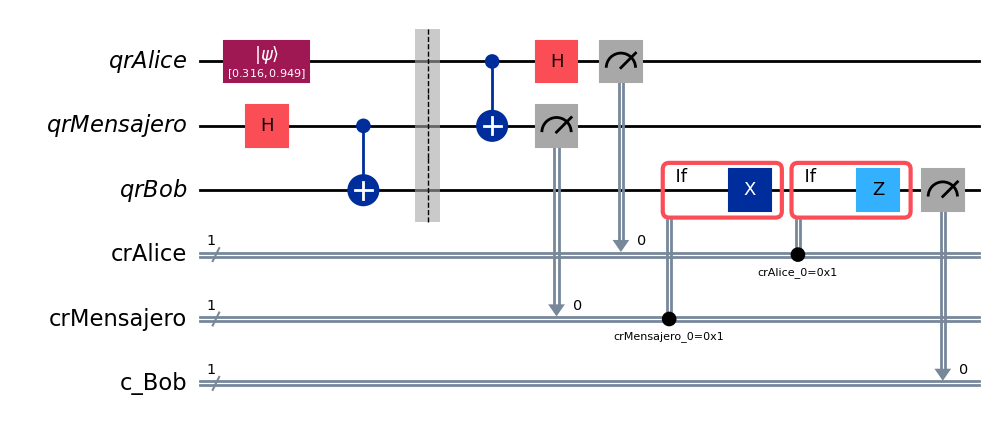

In [12]:
#Estado de entrada
estado = np.array([1,3], dtype=float)
estado /= np.sqrt(sum(estado**2))

#Creamos el circuito
qc = teleportacion(estado)

#Añadimos un registro extra para ver el estado final
crBob = ClassicalRegister(1, 'c_Bob')
qc.add_register(crBob)

qc.measure(qrBob[0], crBob[0])
qc.draw('mpl')

Transpilamos y ejecutamos el circuito en simulador.

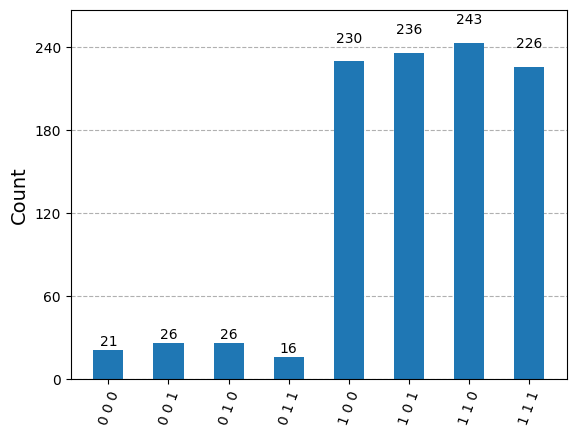

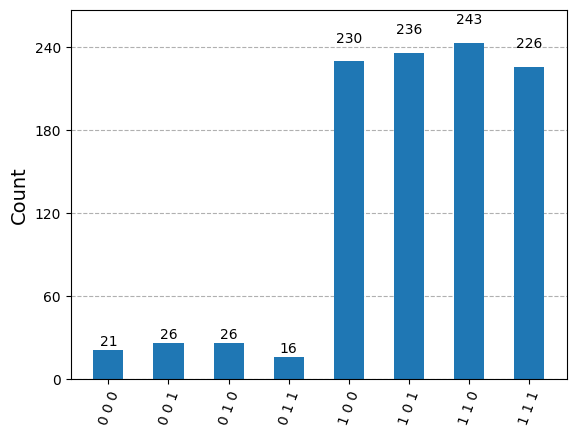

In [13]:
backend = AerSimulator()

qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vamos a obtener solamente las cuentas del último qubit. Para eso usamos las cuentas marginales.

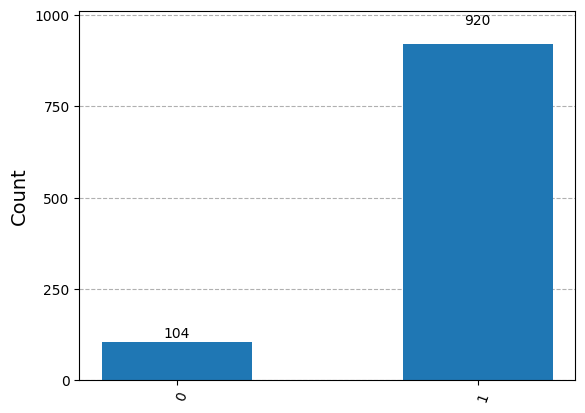

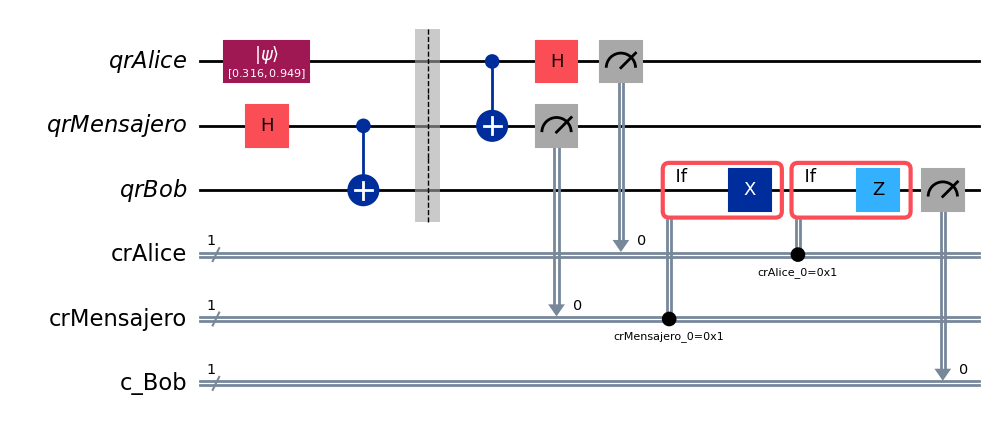

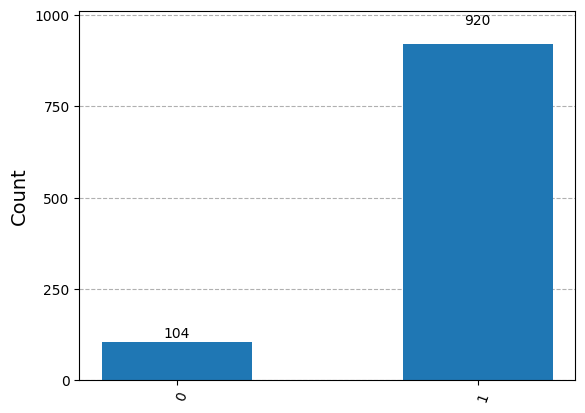

In [14]:
estado = np.array([1,3], dtype=float)
estado /= np.sqrt(sum(estado**2))

qc = teleportacion(estado)

#Añadimos un registro extra para ver el estado final
crBob = ClassicalRegister(1, 'c_Bob')
qc.add_register(crBob)

qc.measure(2, 2)
qc.draw('mpl')

backend = AerSimulator()

qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

# Indicamos cual es el registro de interes
indices = [2]

result_marginal = marginal_counts(result, indices=indices)
marginal_counts_value = result_marginal.get_counts()

plot_histogram(marginal_counts_value)

In [15]:
estado**2

array([0.1, 0.9])

Podemos ver que coinciden.

---
# Ejecución en ordenador real

Ahora vamos a ejecutar el circuito en un ordenador cuántico real.

In [17]:
#Para una sola vez
service = QiskitRuntimeService(channel='ibm_quantum', #o ibm cloud en otros casos
                                token = '8f7a8e0bdf5f9ba503fc5bdec3bff688d26de8c2abffbb7acd7652a8301b1b4aeeb6c6be71fce6ef6df3b6329e332669b737d5a29fb22eced45b433fbf866b31')

#Si queremos guardarlo
QiskitRuntimeService.save_account(channel='ibm_quantum', #o ibm cloud en otros casos
                                token = '8f7a8e0bdf5f9ba503fc5bdec3bff688d26de8c2abffbb7acd7652a8301b1b4aeeb6c6be71fce6ef6df3b6329e332669b737d5a29fb22eced45b433fbf866b31',
                                overwrite=True)

In [18]:
#Escogemos el backend menos ocupado
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=3)

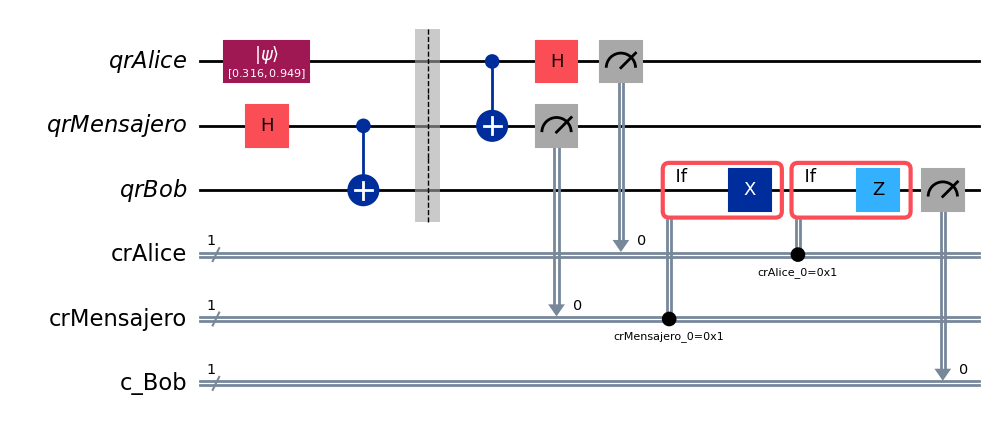

In [19]:
#Objeto que nos hará todo el tema del transpilado. Le decimos el backend y cuanto queremos que optimice el circuito.
# 0 : nada, 3: optimización fuerte (más lento)
pass_Manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

#Generamos el circuito transpilado
estado = np.array([1,3], dtype=float)
estado /= np.sqrt(sum(estado**2))

qc = teleportacion(estado)

#Añadimos un registro extra para ver el estado final
crBob = ClassicalRegister(1, 'c_Bob')
qc.add_register(crBob)

qc.measure(2, 2)
qc.draw('mpl')

qc_transpiled = pass_Manager.run(qc)

In [20]:
#Preparamos el sampler
sampler = SamplerV2(mode=backend)

job = sampler.run([qc_transpiled])#Aqui podemos meter varios circuitos a la vez

#Mostramos el estado del job
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cy2mkvz01rbg008hvrz0
>>> Job Status: QUEUED


In [23]:
#Por si quieres ir comprobando si ya está
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


In [24]:
#Si tarda mucho, poned esto
job = service.job('cy2mkvz01rbg008hvrz0')

In [25]:
#Obtenemos los resultados
result = job.result()[0]

#Resultados de medidas
counts = result.data.c_Bob.get_counts()

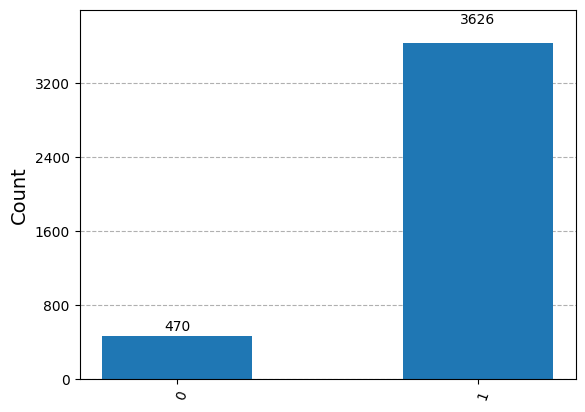

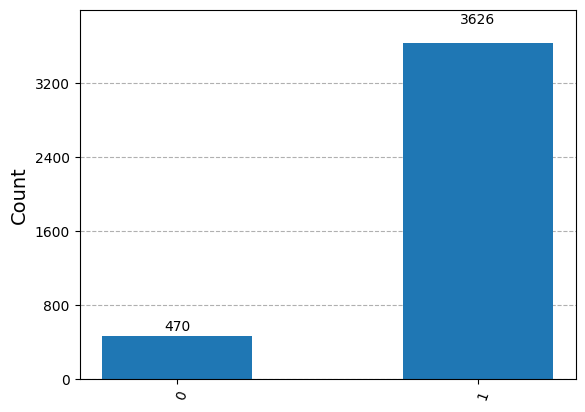

In [26]:
plot_histogram(counts)

Vamos a obtener las quasiprobabilidades.

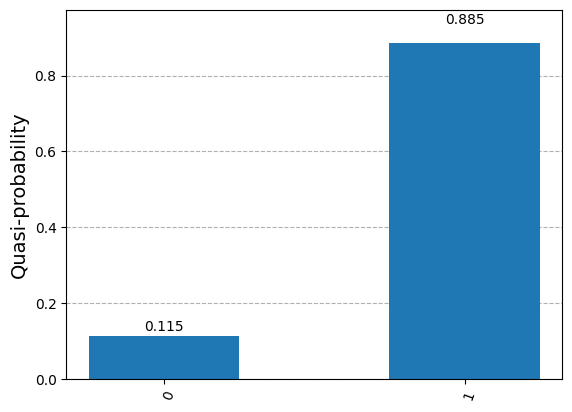

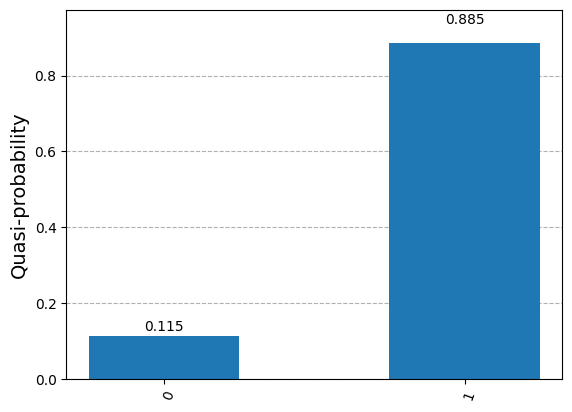

In [27]:
total = 0
for key in counts.keys(): total += counts[key]
#Normalizamos
dists = {key:counts[key]/total for key in counts.keys()}
plot_histogram(dists)

Vemos que hay un ligero error en este caso.